# Deep Dream

Deep Dream, or *Inceptionism*, was introduced by Google in [this](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) blogpost. Deep Dream is an algorithm that optimizes an input image so that it maximizes its activations in certain layer(s) of a pretrained network. By this optimization process, different patterns, objects or shapes appear in the image based on what the neurons of the network have previously learned. Here is an example:

<img src="figs/skyarrow.png">

In this exercise we will implement the algorithm in Keras and test it on some example images to see its effect.

In [1]:
import matplotlib.pyplot as plt  
%matplotlib inline

In [2]:
from keras.applications import vgg16
from keras.layers import Input
from dream import *

Using TensorFlow backend.


We will use the same image for the example. 

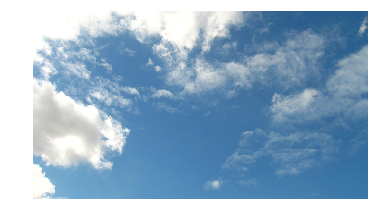

In [3]:
from scipy.misc import imread

img_dir = '../images/dream/sky1024px.jpg'
I = imread(img_dir)
plt.imshow(I)
plt.axis('off')
plt.show()

Here are the settings we will use, including the layers of the network we want to "dream" and the weights for each loss term.

In [4]:
settings = {'features': {'block5_conv1': 0.05,
                         'block5_conv2': 0.1},
            'continuity': 0.1,
            'dream_l2': 0.02}

We load the pretrained network:

In [5]:
from keras.preprocessing.image import load_img

width, height = load_img(img_dir).size
img_height = 224
img_width = int(width * img_height / height)

img_size = (img_height, img_width, 3)
dream_in = Input(batch_shape=(1,) + img_size)
model = vgg16.VGG16(input_tensor=dream_in,weights='imagenet', include_top=False)

Deep Dream is a gradient ascent process that tries to maximize the L2 norm of activations of certain layer(s) of the network. Let's define the loss:

In [6]:
# dictionary with all layers
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# define the loss
loss = K.variable(0.)

for layer_name in settings['features']:
    
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    shape = layer_dict[layer_name].output_shape
    
    # Maximize L2 norm of activations: loss is -activations
    # we avoid border artifacts by only involving non-border pixels in the loss
    loss -= coeff * K.sum(K.square(x[:, 2: shape[1] - 2, 2: shape[2] - 2, :])) / np.prod(shape[1:])

Some additional loss terms are added to make the image look nicer:

In [7]:
# add continuity loss (gives image local coherence, can result in an artful blur)
loss += settings['continuity'] * continuity_loss(dream_in,img_height, img_width) / np.prod(img_size)
# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
loss += settings['dream_l2'] * K.sum(K.square(dream_in)) / np.prod(img_size)

We define the function that will compute the gradients ```grads``` of the image in ```dream_in``` based on the ```loss``` we just defined. This function is the one that will be used iteratively to update the image based on the gradients.

In [8]:
# compute the gradients of the dream wrt the loss
grads = K.gradients(loss, dream_in)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([dream_in], outputs)

Let's run it. We will run 5 iterations, in which we will forward the image, compute the gradients based on the loss and apply the gradients to the image.

In [9]:
import time
evaluator = Evaluator(img_size,f_outputs)

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the loss

ims = []
iterations = 5

x = preprocess_image(img_dir,img_height, img_width)

for i in range(iterations):
    t = time.time()
    # run L-BFGS
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print(i,'Current loss value:', min_val,time.time()-t,'seconds.')
    # decode the dream and save it
    x = x.reshape(img_size)
    img = deprocess_image(np.copy(x),img_height, img_width)
    ims.append(img)

0 Current loss value: -62.2966 26.38552975654602 seconds.
1 Current loss value: -402.707 26.20611810684204 seconds.
2 Current loss value: -1132.82 27.24574327468872 seconds.
3 Current loss value: -3130.34 26.601906538009644 seconds.
4 Current loss value: -7362.03 26.2393639087677 seconds.


We can display the image for the last 5 iterations:

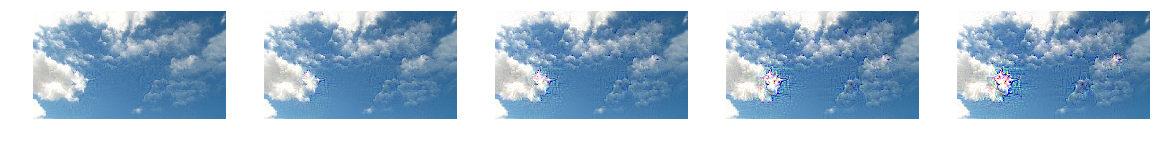

In [10]:
f, axarr = plt.subplots(1, len(ims[:5]),figsize=(20,20))

for i,im in enumerate(ims[:5]):
    axarr[i].imshow(im)
    axarr[i].axis('off')
plt.show()

And let's display the final image with higher resolution.

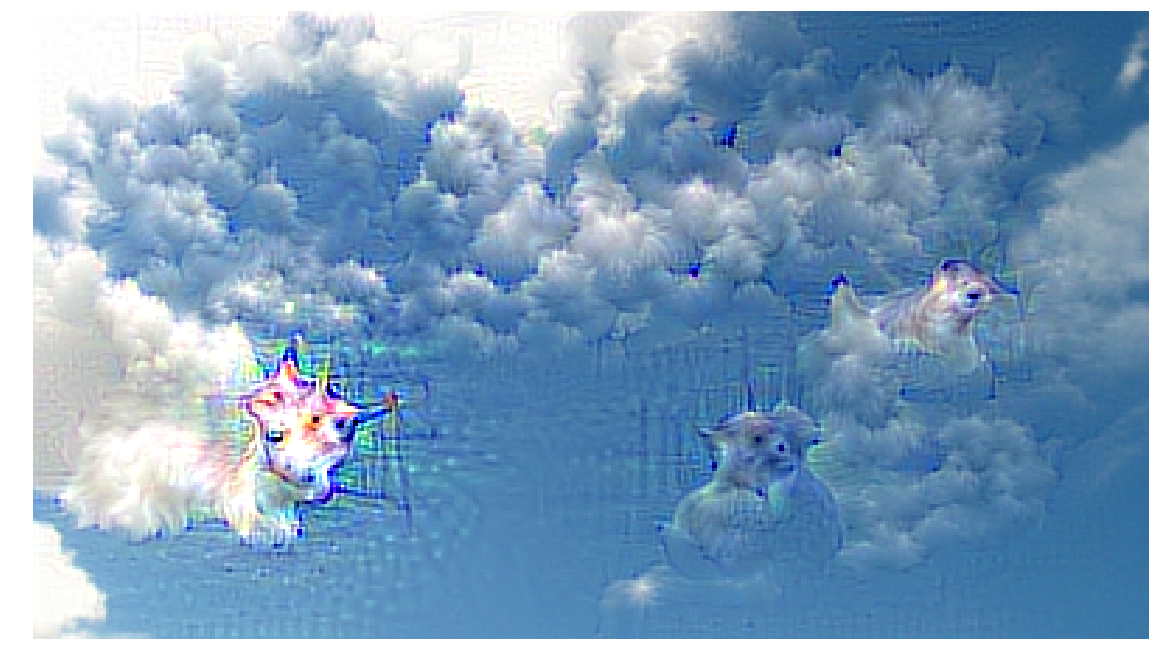

In [11]:
plt.figure(figsize=(20,20)) 
plt.imshow(ims[-1])
plt.axis('off')
plt.show()

Through this iterative process, we see that some shapes, patterns and even object-like blobs have emerged in the image.

**Exercise:** You can now try the algorithm with different images from the ```images``` folder. You can also experiment with different layers in the network, different combinations and different weights.